## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [116]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [117]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [118]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [119]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [120]:
df[df['converted'] == 1].user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [121]:
df_all = df[(df['group'] != 'treatment') & (df['landing_page'] != 'old_page')] + df[(df['group'] != 'control') & (df['landing_page'] != 'new_page')]
df_all.shape[0]

3893

f. Do any of the rows have missing values?

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [123]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [124]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [125]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [126]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [127]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [128]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [129]:
df2 = df2[df2['user_id'] != 773192]
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [130]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959749882133504

b. Given that an individual was in the `control` group, what is the probability they converted?

In [131]:
df_c = df2[df2['group'] == 'control']
df_c[df_c['converted'] == 1].shape[0] / df_c.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [132]:
df_t = df2[df2['group'] == 'treatment']
df_t[df_t['converted'] == 1].shape[0] / df_t.shape[0]

0.11880888313869065

d. What is the probability that an individual received the new page?

In [133]:
df_t.shape[0] / df2.shape[0]

0.5000602237570677

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer :**

Well, since the probability of an individual that was browser through the _New Page_ is similar of the probability of an individual that was browser through the _old Page_, the _New Page_ won't leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer :**

$ H _0 $ : the _New page_ $ \leq $  _old page_


$ H _1 $ : the _New page_ $ > $ _old page_

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [134]:
df_ab = pd.read_csv('ab_data.csv')
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [135]:
p_new = df_ab['converted'].mean()
p_new

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [136]:
p_old = df_ab['converted'].mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [137]:
n_new = df_ab[(df_ab['group'] == 'treatment') & (df_ab['landing_page'] == 'new_page')].shape[0]
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [138]:
n_old =df_ab[(df_ab['group'] == 'control') & (df_ab['landing_page'] == 'old_page')].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [139]:
new_page_converted = np.random.binomial(n_new, p_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [140]:
old_page_converted = np.random.binomial(n_old, p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [141]:
obs_diff = new_page_converted/n_new - old_page_converted/n_old
obs_diff

-0.00014727765151451022

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [142]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted/n_new) - (old_page_converted/n_old))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [143]:
#convert to numpy array
p_diffs = np.array(p_diffs)

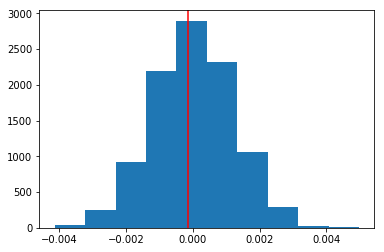

In [144]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color="red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [145]:
actual_diffs = df_ab.query('group == "treatment"')['converted'].mean() - df_ab.query('group == "control"')['converted'].mean()
(p_diffs > actual_diffs).mean()

0.89039999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

we computed the p-value in part **j** , and since the p-value is over 0.05 , so we _fail to reject the null hypothesis_ 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [146]:
import statsmodels.api as sm

convert_old = df_ab.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df_ab.query("landing_page == 'new_page' and converted == 1").shape[0]

n_old = df_ab[(df_ab['group'] == 'control') & (df_ab['landing_page'] == 'old_page')].shape[0]
n_new = df_ab[(df_ab['group'] == 'treatment') & (df_ab['landing_page'] == 'new_page')].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [147]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

(-1.3950792582610225, 0.91850402990848123)

In [148]:
from scipy.stats import norm

# how significant our z-score is
print(norm.cdf(z_score))

# what our critical value at 95% confidence 
print(norm.ppf(1-(0.05/2)))

0.0814959700915
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

The z-score here is inside our critical value of -1.96 - 1.96 and the p-value is still bigger that 0.05. 

This means the z-score and p-value agree with the findings in parts j and k, that there is no profound difference in the conversions of each landing page, so we fail reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**

Logistic regression, whitch is : _multiple regression but with an outcome variable that is a categorical variable and predictor variables that are continuous_

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [149]:
import statsmodels.api as sm
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [150]:
df2['intercept'] = 1
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lm.fit()
result

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [151]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               8.068e-06
Time:                        15:33:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1901
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.145      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.310      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**


The p-value associated with ab_page is 0.19


The $ H _0 $ in part-c and part-e is : that there is no difference between the treatment and control group.


while the $ H _1 $ : is that there is difference between the treatment and control group

**in the regression model we have the following hypotheses:** 

$ H _0  = \beta _1 \equiv 0 $

$ H _1  = \beta _1 \neq 0 $

**which is the same as testing:**




$ H _0  = P _{old} \equiv P _{new} $

$ H _1  = P _{old} \neq P _{new} $

**However, in Part II, the hypothesis test was conducted as:**


$ H _0  = P _{old} \leq P _{new} $

$ H _1  = P _{old} < P _{new} $


**We actually have an effect that the old page has slightly better conversion, the p-value here is essentially 2(1 - (value)), to shade the tails. It essentially suggests there is not statistical evidence of a difference in the two conversion rates, but the connection between the p-value here and the p-value above is a bit disconnected because of the directional component of the previous alternative hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**


adding other factors to the regression model will complete the picture of all the things that influencene the wibsite, consider other factors because you may be able to find factor(s) that have significant impact to conversion, and then may take actions to increase conversion. For example, if a particular day of week or a particular type of customer (age, gender, area of living) has more conversion rate, we can either try to get more customer in that day or type, or try to understand why the other day/type doesn't work well and fix that.
However, adding too many terms may cause long processing time to fit regression model. Also, it may become difficult to understand which term has significant impact and we should work on because some terms are related (like area, number of bathrooms and number of bedrooms, in home price example in the lecture), and some terms are not so easy to change and thus may leads to small practical significant.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [156]:
df_c = pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [157]:
# checking all the country column values
df_c['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [159]:
df_c2 = df_c.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_c2.head()

,country,timestamp,group,landing_page,converted,treatment,control,ab_page,intercept
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1


In [161]:
df_c2[['US', 'UK', 'CA']] = pd.get_dummies(df_c2['country'])

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [162]:
lm2 = sm.Logit(df_c2['converted'], df_c2[['intercept', 'US', 'UK']])
result2 = lm2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               1.520e-05
Time:                        15:50:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.745      0.456      -0.016       0.036
==============================================================================
"""

Looks like there isn't any interaction between country and page has any impact on the conversion rate since all of the p-values are still bigger than 0.05

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])